In [1]:
import json
from collections import defaultdict
from IPython.display import Markdown, Image, display
import random
import math
import time
from IPython.display import clear_output


## Representación del laberinto

En la siguiente imagen se muestra el laberinto utilizado para entrenar el agente.


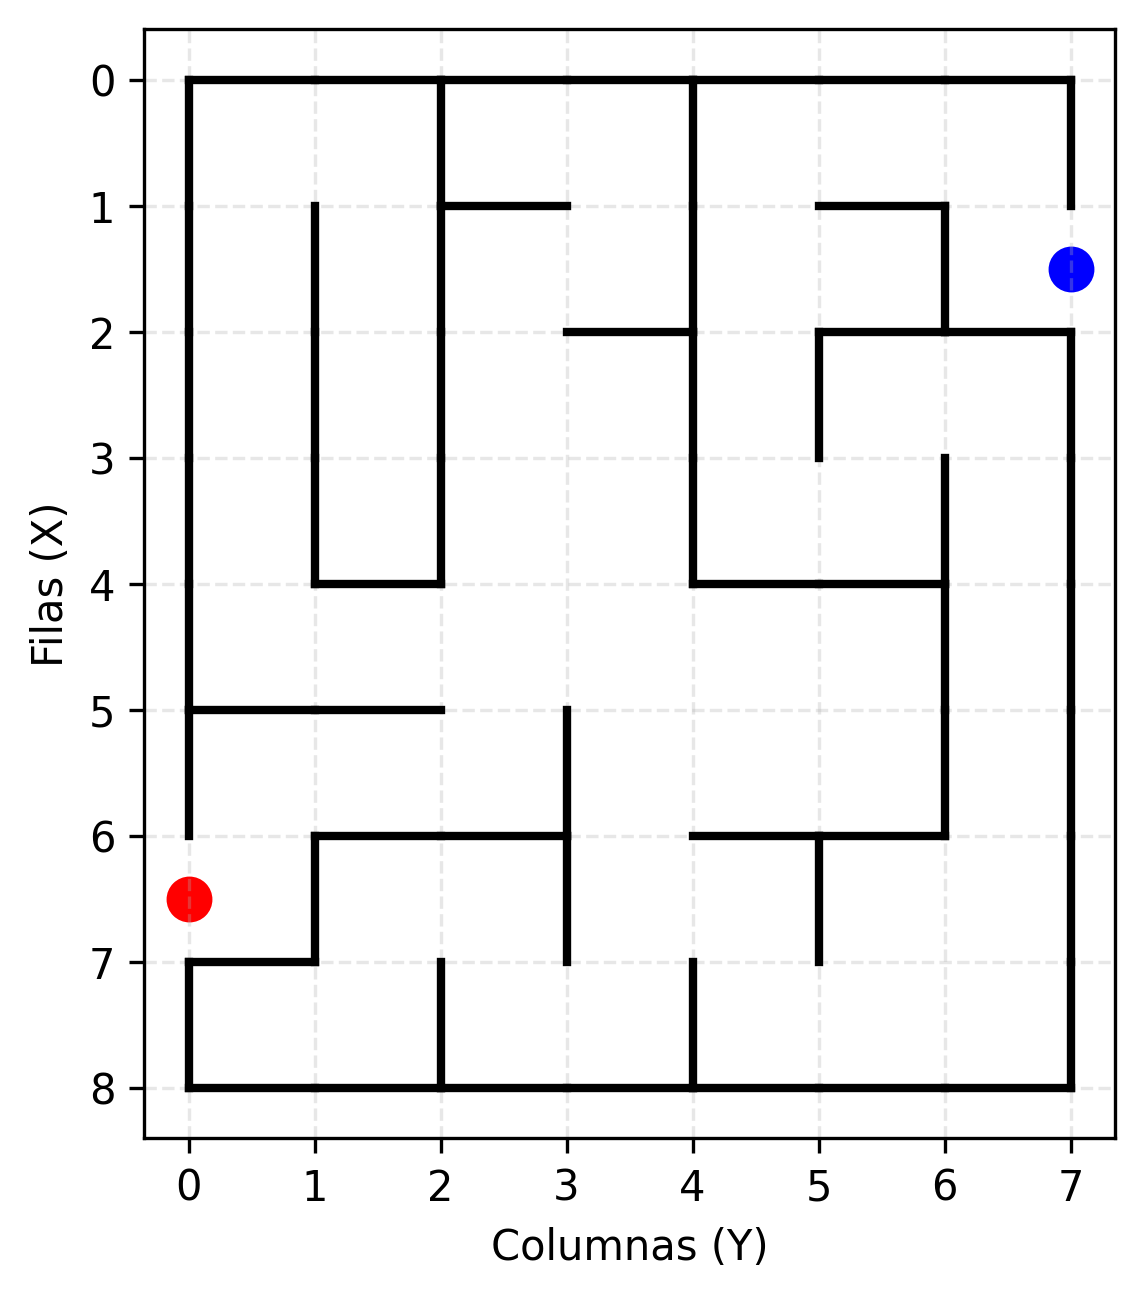

In [2]:
display(Markdown("""
## Representación del laberinto

En la siguiente imagen se muestra el laberinto utilizado para entrenar el agente.
"""))

display(Image("/home/jovyan/work/Laberinto.png", width=200))


In [3]:
# Ruta del archivo del laberinto a cargar
Laberinto = "/home/jovyan/work/laberinto.txt"  

In [4]:
class MazeEnv:
    """
    Ambiente de laberinto para aprendizaje por refuerzo.

    - El laberinto se carga desde un archivo de texto.
    - Cada estado es una celda (fila, columna).
    - El agente empieza en 'start' y debe llegar a 'goal'.
    """
    def __init__(self, maze_path, start=None, goal=None):
        
        self.maze_path = maze_path

        # Load maze + auto-detect start/goal
        self._load_maze(maze_path)

        # If user provides start/goal, override automatic ones
        self.start = start if start is not None else self.auto_start
        self.goal  = goal  if goal  is not None else self.auto_goal

        self.state = self.start


    def _load_maze(self, path):
        """
        Lee el archivo del laberinto.

        Formato del archivo:
        - Línea 1: n_rows n_cols
        - Línea 2: k
        - Siguientes k líneas: x1 y1 x2 y2 (coordenadas de vértices)
        """
        with open(path, "r") as f:
            lines = [l.strip() for l in f if l.strip()]

        orig_rows, orig_cols = map(int, lines[0].split())

        # --- Dimensions after transpose ---
        self.n_rows = orig_rows    # filas nuevas
        self.n_cols = orig_cols   # columnas nuevas

        k = int(lines[1])

        self.walls = set()

        for i in range(k):
            x1, y1, x2, y2 = map(int, lines[2 + i].split())

            # --- PURE TRANSPOSE (x,y) -> (y,x) ---
            tx1, ty1 = y1, x1
            tx2, ty2 = y2, x2

            p1 = (tx1, ty1)
            p2 = (tx2, ty2)

            seg = (p1, p2) if p1 <= p2 else (p2, p1)
            self.walls.add(seg)
            
        self._detect_start_and_goal()



    def _detect_start_and_goal(self):
        """
        Detect:
        - start: open cell on left border
        - goal: open cell on right border
        Saves them as: self.auto_start, self.auto_goal
        """
        # ---------- LEFT BORDER (start) ----------
        for r in range(self.n_rows):
            p1 = (0, r)
            p2 = (0, r+1)
            seg = (p1, p2) if p1 <= p2 else (p2, p1)

            if seg not in self.walls:   # open
                self.auto_start = (r, 0)
                break

        # ---------- RIGHT BORDER (goal) ----------
        for r in range(self.n_rows):
            p1 = (self.n_cols, r)
            p2 = (self.n_cols, r+1)
            seg = (p1, p2) if p1 <= p2 else (p2, p1)

            if seg not in self.walls:   # open
                self.auto_goal = (r, self.n_cols - 1)
                break




    def reset(self):
        """Reinicia el ambiente al estado inicial y lo retorna."""
        self.state = self.start
        return self.state

    def is_terminal(self, state):
        """Retorna True si el estado es la meta."""
        return state == self.goal

    def _edge_for_move(self, state, action):
        """
        Devuelve el segmento (p1, p2) correspondiente al borde
        que se cruza al intentar ejecutar 'action' desde 'state'.
        """
        r, c = state

        if action == "up":
            # borde horizontal arriba de la celda (r, c)
            p1 = (c,   r)
            p2 = (c+1, r)
        elif action == "down":
            # borde horizontal debajo de la celda (r, c)
            p1 = (c,   r+1)
            p2 = (c+1, r+1)
        elif action == "left":
            # borde vertical a la izquierda de la celda (r, c)
            p1 = (c,   r)
            p2 = (c,   r+1)
        elif action == "right":
            # borde vertical a la derecha de la celda (r, c)
            p1 = (c+1, r)
            p2 = (c+1, r+1)
        else:
            raise ValueError(f"Acción desconocida: {action}")

        return (p1, p2) if p1 <= p2 else (p2, p1)

    def _move(self, state, action):
        """
        Calcula la celda destino SIN verificar paredes ni límites.
        Solo aplica el desplazamiento en la grilla.
        """
        r, c = state

        if action == "up":
            r2, c2 = r - 1, c
        elif action == "down":
            r2, c2 = r + 1, c
        elif action == "left":
            r2, c2 = r, c - 1
        elif action == "right":
            r2, c2 = r, c + 1
        else:
            raise ValueError(f"Acción desconocida: {action}")

        return r2, c2

    def step(self, action):
        """
        Ejecuta una acción y actualiza el estado del ambiente.

        Retorna:
        - next_state: siguiente estado (fila, columna)
        - reward: recompensa obtenida
        - done: True si se llegó a la meta
        """
        assert action in ["up", "down", "left", "right"], "Acción inválida"

        # 1) Verificar si la acción está bloqueada por una pared
        edge = self._edge_for_move(self.state, action)
        blocked = edge in self.walls

        # 2) Intento de movimiento ignorando paredes
        r2, c2 = self._move(self.state, action)

        # 3) Verificar límites del tablero
        out_of_bounds = not (0 <= r2 < self.n_rows and 0 <= c2 < self.n_cols)

        if blocked or out_of_bounds:
            # Movimiento inválido: se queda en el mismo estado
            next_state = self.state
            reward = -5.0  # penalizamos intentos inválidos
        else:
            next_state = (r2, c2)
            reward = -1.0  # costo por paso

        done = False
        if next_state == self.goal:
            reward = 100.0  # recompensa por llegar
            done = True

        self.state = next_state
        return next_state, reward, done

    def get_actions(self, state):
        """
        Retorna la lista de acciones disponibles desde un estado.
        (En este caso siempre son las cuatro posibles.)
        """
        return ["up", "down", "left", "right"]

In [5]:
class QLearningAgent:
    """
    Agente que aprende a resolver el laberinto usando Q-learning.
    """

    def __init__(self, env, 
                 alpha=0.5,
                 gamma=0.99,
                 epsilon=1.0,
                 epsilon_min=0.01,
                 epsilon_decay=0.999):
        """
        Parámetros
        ----------
        env : MazeEnv
            Ambiente de laberinto.
        alpha : float
            Tasa de aprendizaje.
        gamma : float
            Factor de descuento.
        epsilon : float
            Probabilidad inicial de exploración (ε-greedy).
        epsilon_min : float
            Valor mínimo de epsilon.
        epsilon_decay : float
            Factor de decaimiento multiplicativo por episodio.
        """
        self.env = env
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = float(epsilon)
        self.epsilon_min = float(epsilon_min)
        self.epsilon_decay = float(epsilon_decay)

        # Q-table: diccionario con valor por defecto 0.0
        # Clave: (state, action)  ->  Valor Q(s,a)
        self.q = defaultdict(float)

    def get_q(self, state, action):
        """Retorna Q(s, a). Si no existe, devuelve 0.0."""
        return self.q[(state, action)]

    def best_action(self, state):
        """
        Retorna la mejor acción (greedy) para un estado según la Q-table.
        Si hay empate, elige una al azar entre las mejores.
        """
        actions = self.env.get_actions(state)
        q_values = [self.get_q(state, a) for a in actions]
        max_q = max(q_values)
        best_actions = [a for a, qv in zip(actions, q_values) if qv == max_q]
        return random.choice(best_actions)

    def choose_action(self, state):
        """
        Estrategia ε-greedy:
        - Con probabilidad ε, elige una acción aleatoria (exploración).
        - Con probabilidad 1-ε, elige la mejor acción (explotación).
        """
        if random.random() < self.epsilon:
            return random.choice(self.env.get_actions(state))
        return self.best_action(state)

    def update(self, state, action, reward, next_state, done):
        """
        Actualiza la Q-table usando la regla de Q-learning:

        Q(s,a) ← Q(s,a) + α [ r + γ max_a' Q(s', a') − Q(s,a) ]
        """
        current_q = self.get_q(state, action)

        if done:
            target = reward
        else:
            max_next_q = max(
                self.get_q(next_state, a)
                for a in self.env.get_actions(next_state)
            )
            target = reward + self.gamma * max_next_q

        new_q = current_q + self.alpha * (target - current_q)
        self.q[(state, action)] = new_q

    def decay_epsilon(self):
        """
        Reduce epsilon multiplicándolo por epsilon_decay,
        sin bajar de epsilon_min.
        """
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
            if self.epsilon < self.epsilon_min:
                self.epsilon = self.epsilon_min


In [6]:
def train_qlearning(env, agent, episodes=5000, max_steps_per_episode=200):
    rewards_per_episode = []
    successes = 0

    for ep in range(episodes):
        state = env.reset()
        total_reward = 0.0

        for step in range(max_steps_per_episode):
            action = agent.choose_action(state)
            next_state, reward, done = env.step(action)

            agent.update(state, action, reward, next_state, done)
            state = next_state
            total_reward += reward

            if done:
                successes += 1
                break

        agent.decay_epsilon()
        rewards_per_episode.append(total_reward)

        if (ep + 1) % 500 == 0:
            print(f"Episodio {ep+1}/{episodes} - recompensa: {total_reward:.2f}, "
                  f"ε={agent.epsilon:.3f}, éxitos acumulados={successes}")

    return rewards_per_episode



def save_qtable(agent, path):
    """
    Guarda la Q-table del agente en un archivo JSON.

    Las claves ((fila, columna), acción) se convierten a strings
    del tipo "r,c,action".
    """
    data = {}
    for (state, action), value in agent.q.items():
        r, c = state
        key = f"{r},{c},{action}"
        data[key] = value

    with open(path, "w") as f:
        json.dump(data, f)


def load_qtable(agent, path):
    """
    Carga una Q-table desde un archivo JSON y la asigna al agente.
    """
    with open(path, "r") as f:
        data = json.load(f)

    agent.q.clear()
    for key, value in data.items():
        r, c, action = key.split(",")
        state = (int(r), int(c))
        agent.q[(state, action)] = float(value)


def run_greedy_episode(env, agent, max_steps=200, render=True):
    """
    Ejecuta un episodio usando exclusivamente la política greedy (sin exploración).

    - Pone epsilon = 0 temporalmente.
    - Muestra paso a paso el recorrido si render=True.
    - Devuelve la lista de estados visitados.
    """
    state = env.reset()
    path = [state]
    total_reward = 0.0

    # Guardamos el epsilon original y lo ponemos en 0 para este episodio
    old_epsilon = agent.epsilon
    agent.epsilon = 0.0

    for step in range(max_steps):
        # Siempre elegimos la mejor acción según la Q-table
        action = agent.best_action(state)
        next_state, reward, done = env.step(action)

        total_reward += reward
        path.append(next_state)

        if render:
            print(f"Paso {step+1}: {state} --{action}--> {next_state}, R={reward}")

        state = next_state
        if done:
            break

    # Restauramos el epsilon original
    agent.epsilon = old_epsilon

    print(f"\nTerminado en {len(path)-1} pasos, recompensa total {total_reward}")
    return path


In [7]:
maze_path = Laberinto

env = MazeEnv(maze_path)
agent = QLearningAgent(env,
                       alpha=0.5,
                       gamma=0.99,
                       epsilon=1.0,
                       epsilon_min=0.01,
                       epsilon_decay=0.999)

start = time.time()
rewards = train_qlearning(env, agent, episodes=5000)
end = time.time()

print("Tiempo total de entrenamiento:", end - start, "segundos")


Episodio 500/5000 - recompensa: 20.00, ε=0.606, éxitos acumulados=354
Episodio 1000/5000 - recompensa: 5.00, ε=0.368, éxitos acumulados=854
Episodio 1500/5000 - recompensa: 63.00, ε=0.223, éxitos acumulados=1354
Episodio 2000/5000 - recompensa: 44.00, ε=0.135, éxitos acumulados=1854
Episodio 2500/5000 - recompensa: 69.00, ε=0.082, éxitos acumulados=2354
Episodio 3000/5000 - recompensa: 69.00, ε=0.050, éxitos acumulados=2854
Episodio 3500/5000 - recompensa: 76.00, ε=0.030, éxitos acumulados=3354
Episodio 4000/5000 - recompensa: 76.00, ε=0.018, éxitos acumulados=3854
Episodio 4500/5000 - recompensa: 76.00, ε=0.011, éxitos acumulados=4354
Episodio 5000/5000 - recompensa: 76.00, ε=0.010, éxitos acumulados=4854
Tiempo total de entrenamiento: 1.152329683303833 segundos


In [8]:
save_qtable(agent, "qtable_laberinto.json")


In [9]:
env = MazeEnv(maze_path)
agent = QLearningAgent(env)
load_qtable(agent, "qtable_laberinto.json")

path = run_greedy_episode(env, agent, render=True)


Paso 1: (6, 0) --up--> (5, 0), R=-1.0
Paso 2: (5, 0) --right--> (5, 1), R=-1.0
Paso 3: (5, 1) --right--> (5, 2), R=-1.0
Paso 4: (5, 2) --up--> (4, 2), R=-1.0
Paso 5: (4, 2) --right--> (4, 3), R=-1.0
Paso 6: (4, 3) --down--> (5, 3), R=-1.0
Paso 7: (5, 3) --down--> (6, 3), R=-1.0
Paso 8: (6, 3) --right--> (6, 4), R=-1.0
Paso 9: (6, 4) --down--> (7, 4), R=-1.0
Paso 10: (7, 4) --right--> (7, 5), R=-1.0
Paso 11: (7, 5) --up--> (6, 5), R=-1.0
Paso 12: (6, 5) --right--> (6, 6), R=-1.0
Paso 13: (6, 6) --up--> (5, 6), R=-1.0
Paso 14: (5, 6) --up--> (4, 6), R=-1.0
Paso 15: (4, 6) --up--> (3, 6), R=-1.0
Paso 16: (3, 6) --up--> (2, 6), R=-1.0
Paso 17: (2, 6) --left--> (2, 5), R=-1.0
Paso 18: (2, 5) --down--> (3, 5), R=-1.0
Paso 19: (3, 5) --left--> (3, 4), R=-1.0
Paso 20: (3, 4) --up--> (2, 4), R=-1.0
Paso 21: (2, 4) --up--> (1, 4), R=-1.0
Paso 22: (1, 4) --up--> (0, 4), R=-1.0
Paso 23: (0, 4) --right--> (0, 5), R=-1.0
Paso 24: (0, 5) --right--> (0, 6), R=-1.0
Paso 25: (0, 6) --down--> (1, 6), R=1

In [10]:
"visualización"

'visualización'

In [11]:

def _has_wall(env, p1, p2):
    seg = (p1, p2) if p1 <= p2 else (p2, p1)
    return seg in env.walls


def render_maze_indexed(env, state, step_idx=None):
    rA, cA = state
    rS, cS = env.start
    rG, cG = env.goal

    n_rows = env.n_rows
    n_cols = env.n_cols

    print(f"\nPaso {step_idx} | Agente: {state}")
    print(f"Inicio S: {env.start} | Meta G: {env.goal}\n")

    # ---- Column indices ----
    header = "    "
    for x in range(n_cols):
        header += f"  {x} "
    print(header)

    for y in range(n_rows):
        # ---- Top horizontal walls of row y ----
        line = "    "
        for x in range(n_cols):
            line += "+"

            p1, p2 = (x, y), (x+1, y)
            if _has_wall(env, p1, p2):
                line += "---"
            else:
                line += "   "
        line += "+"
        print(line)

        # ---- Cell contents + vertical walls ----
        line = f"{y:2d}  "

        for x in range(n_cols):
            # Left wall of cell
            p1, p2 = (x, y), (x, y+1)
            if _has_wall(env, p1, p2):
                line += "|"
            else:
                line += " "

            # Cell contents
            if (y, x) == (rA, cA):
                cell = "A"
            elif (y, x) == (rS, cS):
                cell = "S"
            elif (y, x) == (rG, cG):
                cell = "G"
            else:
                cell = " "

            line += f" {cell} "

        # Rightmost vertical wall
        p1, p2 = (n_cols, y), (n_cols, y+1)
        if _has_wall(env, p1, p2):
            line += "|"
        else:
            line += " "

        print(line)

    # ---- Bottom horizontal walls ----
    line = "    "
    y = n_rows
    for x in range(n_cols):
        line += "+"

        p1, p2 = (x, y), (x+1, y)
        if _has_wall(env, p1, p2):
            line += "---"
        else:
            line += "   "
    line += "+"
    print(line)




In [12]:

def animate_indexed(env, path, delay=0.3):
    for i, s in enumerate(path):
        clear_output(wait=True)
        render_maze_indexed(env, s, step_idx=i)
        time.sleep(delay)


In [13]:
env = MazeEnv(maze_path)

agent = QLearningAgent(env)
load_qtable(agent, "qtable_laberinto.json")

path = run_greedy_episode(env, agent, render=True)
animate_indexed(env, path, delay=0.25)



Paso 25 | Agente: (1, 6)
Inicio S: (6, 0) | Meta G: (1, 6)

      0   1   2   3   4   5   6 
    +---+---+---+---+---+---+---+
 0  |       |       |           |
    +   +   +---+   +   +---+   +
 1  |   |   |       |       | A  
    +   +   +   +---+   +---+---+
 2  |   |   |       |   |       |
    +   +   +   +   +   +   +   +
 3  |   |   |       |       |   |
    +   +---+   +   +---+---+   +
 4  |                       |   |
    +---+---+   +   +   +   +   +
 5  |           |           |   |
    +   +---+---+   +---+---+   +
 6    S |       |       |       |
    +---+   +   +   +   +   +   +
 7  |       |       |           |
    +---+---+---+---+---+---+---+
